### Processing Homo CDS DNA Seq by DNA-BERT 

In [19]:
from Bio import SeqIO

def extract_gene_symbol(description):
    parts = description.split(' ')
    for part in parts:
        if part.startswith('gene_symbol:'):
            return part.split(':')[1]
    return None

fasta_file = "Homocdsall.fasta"  

cds_dic = {}
for record in SeqIO.parse(fasta_file, "fasta"):
    gene_symbol = extract_gene_symbol(record.description)
    cds_dic[gene_symbol] = str(record.seq)

In [20]:
len(cds_dic)

19853

In [21]:
a = 0
for k, v in cds_dic.items():
    a += 1
    print(k,v)
    if a ==10:
        break

TRDD1 GAAATAGT
TRDD3 ACTGGGGGATACG
TRDD2 CCTTCCTAC
TRBD1 GGGACAGGGGGC
None NACCCTCCCCTGAAGAACGTGTCCAGCAACGCAGAGTGCCCTGCTTGTTATGAATCTAATGGAACTTCCTGTCATGGGAAGCCCTGGAAATGCTATGAAGAAGAACAGTGTGTCTTTCTAGTTGCAGAACTTAAGAATGGAACACCAGGTGATGGTGCAGATTGA
IGHD1OR15-1A GGTATAACTGGAACAAC
IGHD5OR15-5A GTGGATATAGTGTCTACGATTAC
IGHD2OR15-2A AGAATATTGTAATAGTACTACTTTCTATGCC
IGHD5OR15-5B GTGGATATAGTGTCTACGATTAC
IGHD2OR15-2B AGAATATTGTAATAGTACTACTTTCTATGCC


In [ ]:
# DNA-BERT-2
import os

os.environ['TRANSFORMERS_OFFLINE'] = '1'

# change to your directory installed BERT-2
tokenizer = AutoTokenizer.from_pretrained("/data1/jhhou/network/DNA-BERT/DNABERT-2-117M", trust_remote_code=True)
model = AutoModel.from_pretrained("/data1/jhhou/network/DNA-BERT/DNABERT-2-117M", trust_remote_code=True).to(device)

model.eval()

cds_features_dic = {}

with torch.no_grad():
    for k, v in tqdm(cds_dic.items()):
    
        torch.cuda.empty_cache()

        dna = v
        
        inputs = tokenizer(dna, return_tensors = 'pt')["input_ids"]
        inputs = inputs.to(device)
        hidden_states = model(inputs)[0] # [1, sequence_length, 768]

        # embedding with mean pooling
        embedding_mean = torch.mean(hidden_states[0], dim=0)

        cds_features_dic[k] = embedding_mean.cpu()

In [22]:
import pickle

In [ ]:
''''
with open('cds_DNA_features_dic.pkl', 'wb') as f:
    pickle.dump(cds_features_dic, f)

In [24]:
with open('cds_DNA_features_dic.pkl', 'rb') as f:    
    cds_features_dic = pickle.load(f)

/data1/xpgeng/.conda/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
cds_features_dic['ABL1'].shape

torch.Size([768])

### Processing Homo CDS Protein Seq by Prottrans 

In [26]:
fasta_file = "Homopepall.fasta" 

pep_dic = {}
for record in SeqIO.parse(fasta_file, "fasta"):
    gene_symbol = extract_gene_symbol(record.description)
    pep_dic[gene_symbol] = str(record.seq)

In [27]:
len(pep_dic)

19853

In [ ]:
from bio_embeddings.embed import ProtTransBertBFDEmbedder
import numpy as np
from tqdm import tqdm

# Initialize the embedder
embedder = ProtTransBertBFDEmbedder()

cds_pro_features_dic = {}

for k,v in tqdm(pep_dic.items()):
    
    # Embed the sequence
    embedding = embedder.embed(v)
    
    # Reduce the sequence embedding to a single vector of size 1024
    reduced_embedding = np.mean(embedding, axis=0)
    
    cds_pro_features_dic[k] = reduced_embedding

In [ ]:
''''
with open('cds_pro_features_dic.pkl', 'wb') as f:
    pickle.dump(cds_pro_features_dic, f)

In [28]:
with open('cds_pro_features_dic.pkl', 'rb') as f:    
    cds_pro_features_dic = pickle.load(f)

In [29]:
len(cds_pro_features_dic)

19853

### Protein pdb. file filtering 

In [30]:
# read excel and create name_alphafold_entry_dic
import pandas as pd
# Load spreadsheet
xl = pd.ExcelFile('human_genename_AFid.xlsx')

# Load a sheet into a DataFrame by name
df = xl.parse(xl.sheet_names[0], skiprows=0)

name_alphafold_entry_dic = {}

for index, row in df.iterrows():
    name_alphafold_entry_dic[row[0]] = row[1]
    
print(len(name_alphafold_entry_dic))

20291


In [33]:
a = 0
for k, v in name_alphafold_entry_dic.items():
    a += 1
    print(k,v)
    if a ==10:
        break

Q86UQ4 ABCA13
Q8IZF6 ADGRG4 GPR112
Q8WXG9 ADGRV1 GPR98 KIAA0686 KIAA1943 MASS1 VLGR1
Q09666 AHNAK PM227
Q8IVF2 AHNAK2 C14orf78 KIAA2019
Q12802 AKAP13 BRX HT31 LBC
Q99996 AKAP9 AKAP350 AKAP450 KIAA0803
Q8TCU4 ALMS1 KIAA0328
Q01484 ANK2 ANKB
Q12955 ANK3


In [34]:
name_entry_dic = {}
from tqdm import tqdm
cds_gene_list = []
for k,v in cds_dic.items():       
        cds_gene_list.append(k)
cds_gene_list = list(set(cds_gene_list))

for i in tqdm(cds_gene_list):
    try:
        
        for k,v in name_alphafold_entry_dic.items():       
            if i in v:
                name_entry_dic[i] = k
    except:
        print(i)

 54%|█████████████████████████████▋                         | 10713/19853 [03:09<01:42, 89.28it/s]

None


100%|███████████████████████████████████████████████████████| 19853/19853 [06:07<00:00, 53.97it/s]


In [35]:
a = 0
for k, v in name_entry_dic.items():
    a += 1
    print(k,v)
    if a ==10:
        break

GPR61 Q9BZJ8
CCDC115 Q96NT0
UTS2B Q765I0
AGTPBP1 Q9UPW5
MED4 Q9NPJ6
DEFB128 Q7Z7B8
VPS4A Q9UN37
ZNF486 Q96H40
GFOD2 Q6N063
PIGX Q8TBF5


In [36]:
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
from scipy.spatial import distance_matrix

### Protein Structure Phi and Psi + Distance Matrix

#### plot cds length distribution 

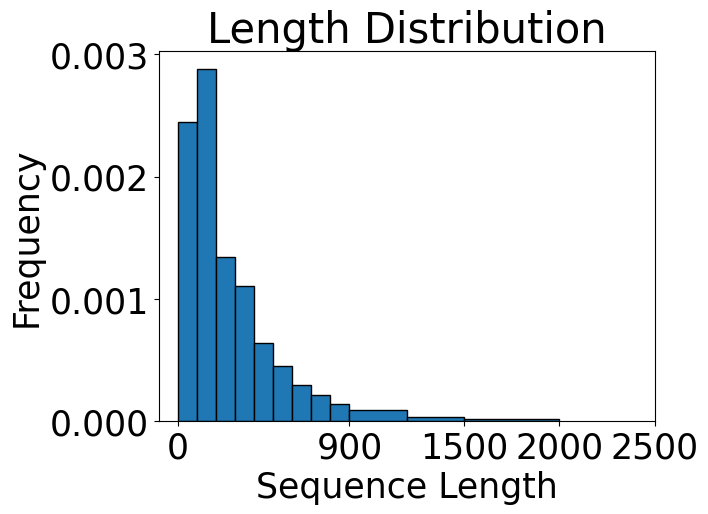

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Set global font size
plt.rcParams.update({'font.size': 25})
# calculate sequence lengths
lengths = [len(seq) for seq in pep_dic.values()]

# define bins for your histogram
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1200, 1500, 2000, np.inf]

# plot histogram
plt.hist(lengths, bins=bins, edgecolor='black', density=True)

# set xticks to be in the middle of the intervals
plt.xticks([0, 900, 1500, 2000, 2500])

plt.title('Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

plt.show()

In [23]:
# calculate sequence lengths
lengths = [len(seq) for seq in pep_dic.values()]

# find lengths over 900
over_900 = [length for length in lengths if length > 900]

# calculate the ratio
ratio = len(over_900) / len(lengths)

print(f"Ratio of sequences over 900 to total sequences: {ratio}")

Ratio of sequences over 900 to total sequences: 0.04951392736614114


#### calculate features 

In [41]:
def pad_or_truncate(angles, fixed_length):
    # 如果列表长度小于 fixed_length，则进行填充
    if len(angles) < fixed_length:
        angles += [0.0] * (fixed_length - len(angles))

    # 如果列表长度大于 fixed_length，则进行截断
    elif len(angles) > fixed_length:
        angles = angles[:fixed_length]

    return angles

In [42]:
# distance matrix
import numpy as np

def adjust_vector(matrix):
    column_means = matrix.mean(axis=0)
    if len(column_means) > 900:
        result = column_means[:900]
    else:
        result = np.pad(column_means, (0, 900 - len(column_means)), 'constant')

    return result

In [43]:
# structure dic

cds_structure_dic = {}

for k,v in tqdm(name_entry_dic.items()):
    try:
        
        # two angles
        pdb_file = '/data1/xpgeng/2024RECOMB/HomoAlphaFold/' + 'AF-' + name_entry_dic[k] +'-F1-model_v4.pdb'  # replace with your PDB file path
        structure = PDBParser().get_structure('pdb_id', pdb_file)
        angles = []
        for model in structure:
            for chain in model:
                try:
                    dssp = DSSP(model, pdb_file, dssp='mkdssp')
                    for key in dssp.keys():
                        angles.append((dssp[key][4] + dssp[key][5])/2)
                except Exception as e:
                    print(f"Failed to run DSSP on chain {chain.id} with error {e}")         
        angles = pad_or_truncate(angles, 900)
                   
        # distance matrix
        coords = [atom.get_coord() for atom in structure.get_atoms() if atom.get_name() == 'CA']
        matrix = distance_matrix(coords, coords)
        distance_900 =  adjust_vector(matrix).tolist()
               
        cds_structure_dic[k] = angles + distance_900
    except:
        print(k, v)

  2%|█▏                                                     | 423/19575 [12:12<4:25:33,  1.20it/s]

TMPO P42167


  4%|██▍                                                    | 848/19575 [21:35<5:39:40,  1.09s/it]

WFDC6 Q9BQY6


  6%|██▉                                                  | 1089/19575 [26:20<10:26:12,  2.03s/it]

SELENOH Q8IZQ5


  6%|███                                                   | 1132/19575 [27:10<6:50:50,  1.34s/it]

SMIM47 D0EPY3


  7%|███▌                                                  | 1285/19575 [30:25<8:29:43,  1.67s/it]

SELENOT P62341


  7%|███▉                                                  | 1418/19575 [34:46<6:03:52,  1.20s/it]

BBC3 Q9BXH1


  8%|████▎                                                 | 1556/19575 [38:02<4:56:05,  1.01it/s]

TRBJ1-2 A0A0J9YX06


  8%|████▎                                                 | 1571/19575 [38:27<8:40:05,  1.73s/it]

GPX2 P18283


  9%|████▉                                                 | 1777/19575 [42:45<4:41:26,  1.05it/s]

ZC3H11C P0DQW0


 10%|█████▎                                                | 1920/19575 [45:57<8:05:41,  1.65s/it]

TPRX2 P0DV77


 10%|█████▍                                                | 1960/19575 [46:47<6:45:31,  1.38s/it]

ZFTRAF1 P0DTL6


 11%|██████▏                                               | 2235/19575 [51:00<3:03:23,  1.58it/s]

SYT1 X6R8R1


 13%|██████▊                                               | 2460/19575 [54:07<2:59:59,  1.58it/s]

GOLGA6L26 P0DX02


 13%|██████▉                                               | 2499/19575 [55:04<4:30:14,  1.05it/s]

TRBJ1-1 A0A0J9YXA8


 13%|██████▉                                               | 2527/19575 [55:23<2:55:06,  1.62it/s]

IGHD1-1 P0DOY5


 13%|███████▏                                              | 2610/19575 [56:10<4:02:06,  1.17it/s]

GPX1 P07203


 16%|████████                                            | 3046/19575 [1:03:21<9:08:55,  1.99s/it]

TAF11L8 P0DW13


 17%|█████████                                           | 3417/19575 [1:10:31<3:42:29,  1.21it/s]

POLR2M Q6EEV4


 18%|█████████▍                                          | 3571/19575 [1:13:24<5:48:17,  1.31s/it]

FAM90A19 P0DV76


 21%|██████████▊                                         | 4081/19575 [1:25:05<6:32:39,  1.52s/it]

TRBJ2-5 A0A0A0MTA4


 22%|███████████▎                                        | 4240/19575 [1:28:38<4:55:13,  1.16s/it]

TMEM276 P0DTL5


 22%|███████████▍                                        | 4285/19575 [1:29:41<5:48:07,  1.37s/it]

TOR2A Q8N2E6


 23%|███████████▊                                        | 4433/19575 [1:33:02<5:21:21,  1.27s/it]

SELENOI Q9C0D9


 23%|████████████▏                                       | 4570/19575 [1:35:49<5:31:08,  1.32s/it]

CALCA P06881


 25%|█████████████▏                                      | 4974/19575 [1:46:04<7:11:47,  1.77s/it]

POLGARF A0A3B3IS91


 28%|██████████████▋                                     | 5527/19575 [1:58:06<4:50:01,  1.24s/it]

HRURF P0DUH7


 29%|███████████████▏                                    | 5706/19575 [2:03:38<8:17:24,  2.15s/it]

LY6S P0DTL4


 30%|███████████████▎                                    | 5775/19575 [2:06:41<9:02:39,  2.36s/it]

GOLGA6L24 P0DX00


 30%|███████████████▍                                    | 5811/19575 [2:07:58<7:06:10,  1.86s/it]

TOMT Q96E66


 30%|███████████████▊                                    | 5967/19575 [2:09:43<6:21:16,  1.68s/it]

SIRPB1 Q5TFQ8


 31%|████████████████▏                                   | 6072/19575 [2:12:26<7:28:06,  1.99s/it]

CTAGE1 Q9HC47


 33%|█████████████████                                   | 6421/19575 [2:21:50<7:58:08,  2.18s/it]

TAF11L7 P0DW12


 35%|██████████████████▏                                 | 6842/19575 [2:31:43<7:03:34,  2.00s/it]

TOR1A Q9H496


 36%|██████████████████▉                                 | 7139/19575 [2:40:02<7:50:30,  2.27s/it]

SYT15 X6R8R1


 37%|███████████████████                                 | 7184/19575 [2:41:24<6:51:08,  1.99s/it]

DIO3 P55073


 38%|███████████████████▌                                | 7380/19575 [2:47:30<5:47:59,  1.71s/it]

LRRC51 Q96E66


 38%|███████████████████▉                                | 7512/19575 [2:51:57<6:27:03,  1.93s/it]

TUNAR A0A1B0GTB2


 39%|████████████████████                                | 7575/19575 [2:53:49<5:43:08,  1.72s/it]

SMIM46 P0DQW1


 40%|████████████████████▌                               | 7754/19575 [2:59:45<6:42:14,  2.04s/it]

SELENOM Q8WWX9


 40%|████████████████████▋                               | 7771/19575 [3:00:13<4:24:43,  1.35s/it]

IGKJ1 A0A0A0MT89


 46%|███████████████████████▋                            | 8910/19575 [3:34:30<4:14:19,  1.43s/it]

HFM1 P60896


 46%|███████████████████████▉                            | 9016/19575 [3:37:57<5:27:50,  1.86s/it]

SYT15B X6R8R1


 46%|████████████████████████▏                           | 9100/19575 [3:40:49<4:44:07,  1.63s/it]

SELENOW P63302


 48%|████████████████████████▊                           | 9328/19575 [3:47:32<5:46:58,  2.03s/it]

SELENOF O60613


 48%|████████████████████████▊                           | 9361/19575 [3:48:26<4:07:44,  1.46s/it]

HMSD P0C7T4


 48%|█████████████████████████                           | 9453/19575 [3:51:26<5:31:41,  1.97s/it]

GOLGA6L25 P0DX01


 49%|█████████████████████████▋                          | 9689/19575 [3:55:25<3:19:02,  1.21s/it]

SELENOO Q9BVL4


 50%|█████████████████████████▉                          | 9748/19575 [3:56:35<6:31:24,  2.39s/it]

TMSB15C P0DX04


 50%|██████████████████████████▏                         | 9851/19575 [3:59:15<3:50:17,  1.42s/it]

TRBD1 P0DPI4


 52%|██████████████████████████▋                        | 10245/19575 [4:08:47<2:51:08,  1.10s/it]

SELENOK Q9Y6D0


 53%|██████████████████████████▊                        | 10293/19575 [4:09:45<4:15:14,  1.65s/it]

CUX1 Q13948


 55%|███████████████████████████▉                       | 10745/19575 [4:17:58<2:17:09,  1.07it/s]

GNG5B A0A804HLA8


 56%|████████████████████████████▊                      | 11035/19575 [4:23:10<2:19:57,  1.02it/s]

GPX4 P36969


 58%|█████████████████████████████▊                     | 11443/19575 [4:32:25<4:00:02,  1.77s/it]

RPSA2 A0A8I5KQE6


 60%|██████████████████████████████▍                    | 11699/19575 [4:40:11<2:59:45,  1.37s/it]

TOR1AIP2 Q9H496


 64%|█████████████████████████████████▊                   | 12497/19575 [4:53:21<52:07,  2.26it/s]

DIO1 P49895


 67%|█████████████████████████████████▉                 | 13024/19575 [4:58:16<1:02:07,  1.76it/s]

SPDYE10 P0DUX0


 67%|███████████████████████████████████▎                 | 13028/19575 [4:58:17<43:24,  2.51it/s]

PRAMEF15 P0DUQ1


 68%|██████████████████████████████████▍                | 13229/19575 [5:00:40<1:03:57,  1.65it/s]

SPDYE12 P0DUX1


 68%|██████████████████████████████████▉                | 13392/19575 [5:02:26<1:32:57,  1.11it/s]

SELENOV P59797


 71%|███████████████████████████████████▉               | 13811/19575 [5:07:01<1:13:25,  1.31it/s]

MSRB1 Q9NZV6


 71%|████████████████████████████████████▍              | 13978/19575 [5:08:57<1:42:32,  1.10s/it]

FAM90A18 P0DV75


 73%|██████████████████████████████████████▊              | 14350/19575 [5:15:52<40:08,  2.17it/s]

SLCO1B3-SLCO1B7 F5H094


 74%|██████████████████████████████████████▉              | 14388/19575 [5:16:15<55:18,  1.56it/s]

LCE7A P0DV60


 74%|█████████████████████████████████████▋             | 14483/19575 [5:17:09<1:02:56,  1.35it/s]

FRG1 Q9H496


 79%|████████████████████████████████████████▏          | 15427/19575 [5:31:23<1:05:57,  1.05it/s]

FAU P62861


 79%|█████████████████████████████████████████▊           | 15456/19575 [5:31:47<46:13,  1.49it/s]

FAM90A16 P0DV73


 80%|██████████████████████████████████████████▌          | 15734/19575 [5:35:43<43:02,  1.49it/s]

SELENON Q9NZV5


 81%|███████████████████████████████████████████▏         | 15933/19575 [5:38:37<59:10,  1.03it/s]

SEPHS2 Q99611


 82%|█████████████████████████████████████████▌         | 15971/19575 [5:39:25<1:07:16,  1.12s/it]

SELENOS Q9BQE4


 82%|█████████████████████████████████████████▋         | 16006/19575 [5:40:03<1:00:27,  1.02s/it]

LRTOMT Q96E66


 84%|████████████████████████████████████████████▍        | 16405/19575 [5:46:17<46:55,  1.13it/s]

TAF11L6 P0DW11


 87%|██████████████████████████████████████████████       | 17034/19575 [5:55:36<27:14,  1.56it/s]

GPX3 P22352


 87%|██████████████████████████████████████████████▎      | 17082/19575 [5:56:20<38:34,  1.08it/s]

PRAMEF9 P0DUQ2


 88%|██████████████████████████████████████████████▌      | 17217/19575 [5:58:14<33:02,  1.19it/s]

MOCS2 O96033


 90%|███████████████████████████████████████████████▍     | 17538/19575 [6:01:25<13:09,  2.58it/s]

DIO2 Q92813


 91%|████████████████████████████████████████████████▏    | 17788/19575 [6:04:48<19:48,  1.50it/s]

TXNRD1 Q16881


 94%|██████████████████████████████████████████████████   | 18483/19575 [6:14:04<09:27,  1.92it/s]

SELENOP P49908


 95%|██████████████████████████████████████████████████▏  | 18523/19575 [6:14:28<14:54,  1.18it/s]

TRBJ2-7 A0A0A0MT78


 95%|██████████████████████████████████████████████████▎  | 18578/19575 [6:15:06<13:59,  1.19it/s]

SPDYE18 P0DV79


 95%|██████████████████████████████████████████████████▍  | 18632/19575 [6:15:50<10:34,  1.49it/s]

TXNRD2 Q9NNW7


 95%|██████████████████████████████████████████████████▌  | 18688/19575 [6:16:29<09:28,  1.56it/s]

CCDC92B A0A8I5KY20


 97%|███████████████████████████████████████████████████▍ | 19008/19575 [6:21:31<08:31,  1.11it/s]

TAF11L10 P0DW14


 98%|███████████████████████████████████████████████████▊ | 19149/19575 [6:23:14<04:29,  1.58it/s]

TRDD1 P0DPR3


100%|████████████████████████████████████████████████████▊| 19489/19575 [6:27:10<01:07,  1.27it/s]

FAM90A17 P0DV74


100%|████████████████████████████████████████████████████▉| 19553/19575 [6:27:52<00:16,  1.36it/s]

H2BN1 P0DW85


100%|█████████████████████████████████████████████████████| 19575/19575 [6:28:07<00:00,  1.19s/it]


In [45]:
''
with open('cds_structure_features_dic_1800.pkl', 'wb') as f:
    pickle.dump(cds_structure_dic, f)

In [3]:
''''
with open('cds_structure_features_dic_1800.pkl', 'rb') as f:    
    cds_structure_dic = pickle.load(f)